In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.special import sph_harm,factorial
from scipy.optimize import fsolve
from scipy.integrate import quad,quad_vec
import numba
from decimal import Decimal, getcontext
getcontext().prec = 50  # 设置精度

In [65]:
e2=1.43997 ; hbarc=197.3269718 ; amu=931.49432
zp=55 ; Ap=112 ; mp=Ap*amu-46.41
z1=54 ; A1=111 ; m1=A1*amu-54.52    #1-> daughter
z2=1  ; A2=1   ; m2=A2*amu+7.288971064
Q=mp-m1-m2
mu=m1*m2/(m1+m2)

$\frac{\partial}{\partial \theta}Y_{l,m}(\theta,\phi)=\frac{1}{(2l+1)\sin\theta}\left [l(l-m+1)\frac{N_{l,m}}{N_{l+1,m}}Y_{l+1,m}(\theta,\phi)-(l+1)(l+m)\frac{N_{l,m}}{N_{l-1,m}}Y_{l-1,m}(\theta,\phi)]      \right],N_{l,m}=\sqrt{\frac{(2l+1)(l-m)!}{4\pi(l+m)!}}$

$V_{so}=V_{so0}\lambda_\pi^2\frac{1}{r}\frac{d}{dr}\frac{1}{1+\exp[(r-R_{so})/a_{so}]}\vec{\sigma}\cdot\vec{l}=\frac{V_{so0}\lambda_\pi^2}{a_{so}}\times \frac{-e^{\frac{r-R_{so}}{a_{so}}}}{r(1+e^{\frac{r-R_{so}}{a_{so}}})^2}\times\frac{J(J+1)-L(L+1)-S(S+1)}{2}$


In [66]:
Vso0=6.2 ; rso=1.01*(A1)**(1/3) ; aso=0.75 ; lambda_pi=np.sqrt(2)

In [ ]:
Nlm=lambda l,m: np.sqrt((2*l+1)/(4*np.pi)*factorial(l-m)/factorial(l+m))
#derivative of Ylm on theta, theta exists on the denominator, so use epsilon to avoid division by zero
def dYlm(l,m,theta,phi):
    epsilon=1e-20
    return (1/(2*l+1)/(np.sin(theta)+epsilon))*(l*(l-m+1)*Nlm(l,m)/Nlm(l+1,m)*sph_harm(m,l+1,phi,theta)-(l+1)*(l+m)*Nlm(l,m)/Nlm(l-1,m)*sph_harm(m,l-1,phi,theta))

#deformed potential,with deformed paras beta, polarization params beta_tilde
def Vn(V0,r0,a0,beta2,beta4,beta2_tilde,beta4_tilde,r,theta):
    Y20=sph_harm(0, 2, 0, theta)  #sph_harm(m,l,phi,theta)
    Y40=sph_harm(0, 4, 0, theta)
    r0_theta=r0*(1+beta2*Y20+beta4*Y40)         #deformation

    # delta_theta=1e-6
    # dY20=(sph_harm(0, 2, 0, theta+delta_theta)-sph_harm(0, 2, 0, theta))/(delta_theta)
    # dY40=(sph_harm(0, 4, 0, theta+delta_theta)-sph_harm(0, 4, 0, theta))/(delta_theta)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    dr0_theta=r0*(beta2*dY20+beta4*dY40)       

# polarization
    a0_theta=a0*np.sqrt(1+(1/r0_theta*dr0_theta)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 

    return -V0/(1+np.exp((r-r0_theta)/a0_theta))

#V_{so}, with lambda_pi being the wave number of pion
def Vso(Vso0,rso,aso,L,S,J,r,theta,beta2,beta4,beta2_tilde,beta4_tilde):
    lambda_pi2=2
    Y20=sph_harm(0, 2, 0, theta)  #sph_harm(m,l,phi,theta)
    Y40=sph_harm(0, 4, 0, theta)
    dY20=dYlm(2,0,theta,0)
    dY40=dYlm(4,0,theta,0)
    #deformation
    rso=rso*(1+beta2*Y20+beta4*Y40) 

    #polarization
    drso=rso*(beta2*dY20+beta4*dY40)       
    aso=aso*np.sqrt(1+(1/rso*drso)**2)*(1+beta2_tilde*Y20+beta4_tilde*Y40) 
    return Vso0*lambda_pi2/aso*(-np.exp((r-rso)/aso)/(r*(1+np.exp((r-rso)/aso))**2))*(J*(J+1)-L*(L+1)-S*(S+1))/2


Piecewise $K_{\lambda}(r,\theta,\phi)$ with $m=0$ and deformed Coulomb

In [68]:
def Vc_vectorized(z1, z2, r, theta, Rc0, beta2, beta4):
    """
    Vectorized deformed-nucleus Coulomb potential.
    r can be scalar or any numpy array.
    """
    r = np.asarray(r)  # ensure array

    # Fixed outer angle (evaluation point)
    Y00 = sph_harm(0, 0, 0, theta).real     #m,l,phi,theta
    Y20 = sph_harm(0, 2, 0, theta).real
    Y40 = sph_harm(0, 4, 0, theta).real
    Rc_fixed = Rc0 * (1 + beta2*Y20 + beta4*Y40)   # Rc at observation angle

    # Rc as function of integration variable
    def Rc_of_theta(t):
        return Rc0 * (1 + beta2*sph_harm(0,2,0,t).real + beta4*sph_harm(0,4,0,t).real)

    # Vectorized Kλ(l, r, θ_int)
    def Klambda(lam, rrr, t):
        inside = rrr <= Rc_of_theta(t)
        res = np.zeros_like(rrr)

        if lam == 2:
            res[inside]  = rrr[inside]**2/5 + rrr[inside]**2*np.log(Rc_of_theta(t)/rrr[inside])
            res[~inside] = Rc_of_theta(t)**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        else:
            res[inside]  = (2*lam+1)*rrr[inside]**2/((lam+3)*(lam-2)) - rrr[inside]**lam/((lam-2)*Rc_of_theta(t)**(lam-2))
            res[~inside] = Rc_of_theta(t)**(lam+3)/((lam+3)*rrr[~inside]**(lam+1))
        return res

    # Integrand for given multipole λ
    def integrand_lam(t, lam):
        Yl0 = sph_harm(0, lam, 0, t).real
        return Yl0 * Klambda(lam, r, t) * np.sin(t)

    # Vectorized integration (0 → π/2, then ×2 for full sphere)
    res0 = 2 * quad_vec(lambda t: integrand_lam(t, 0), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res2 = 2 * quad_vec(lambda t: integrand_lam(t, 2), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]
    res4 = 2 * quad_vec(lambda t: integrand_lam(t, 4), 0, np.pi/2,
                        epsabs=1e-10, epsrel=1e-10)[0]

    V_0 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y00*res0
    V_2 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y20/5*res2
    V_4 = 3*z1*z2*e2 / Rc0**3 * 2*np.pi * Y40/9*res4
    
    # Final Coulomb potential
    Vc_tot = V_0 + V_2 + V_4

    return Vc_tot, V_0, V_2, V_4

24.364701924928077
1.7938911731950426e-06
2.8056661557008907e-13


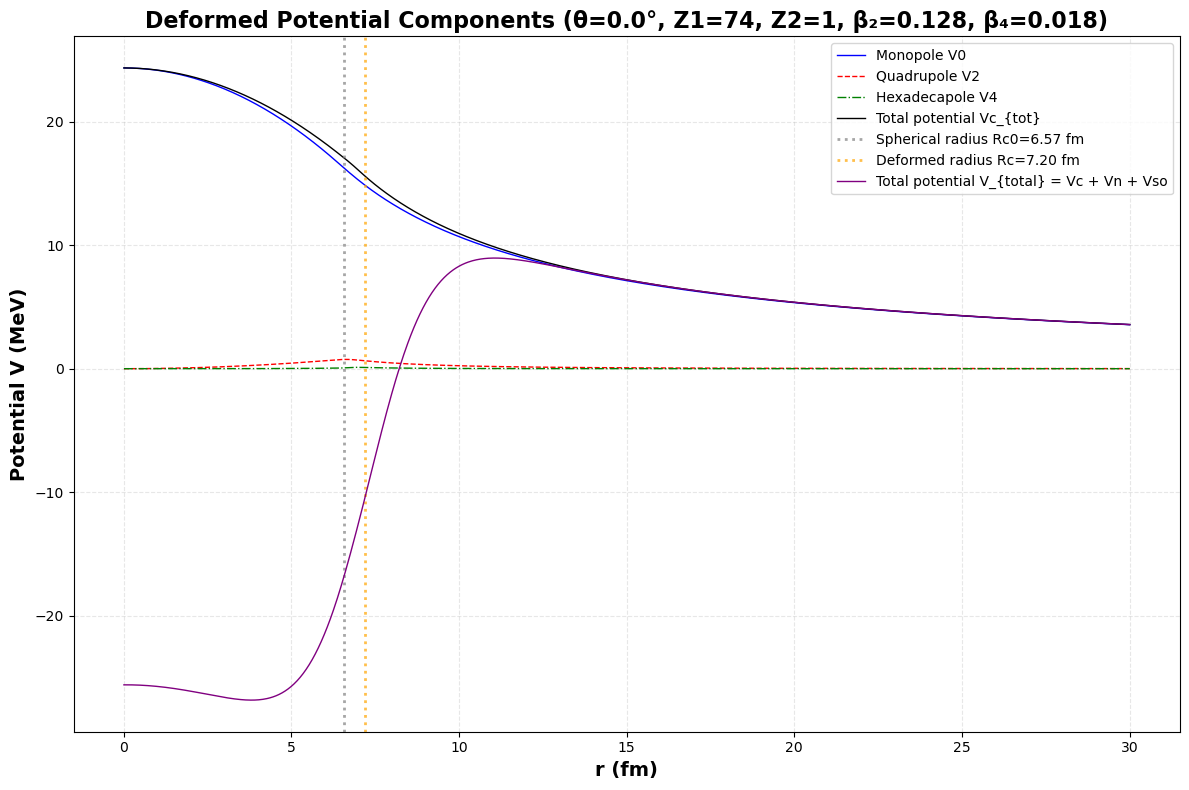

In [69]:
# ================== Parameters ==================
beta2tilde = 0.5  # quadrupole deformation parameter
beta4tilde = 0.2  # hexadecapole deformation parameter
z1, z2 = 74, 1
A1 = 160
Rc0 = 1.21 * A1**(1/3)          # ≈5.95 fm
theta_0 = 0                # theta angle (along major axis)
r = np.linspace(0.01, 30.0, 1000) # avoid too small r

# Deformation parameters - can be modified as needed
beta2 = 0.128  # quadrupole deformation parameter
beta4 = 0.018  # hexadecapole deformation parameter


Vc_tot, V_0, V_2, V_4 = Vc_vectorized(z1, z2, r, theta_0, Rc0, beta2, beta4)
print(V_0[0])
print(V_2[0])
print(V_4[0])

a0=0.637 ; r0=1.19*A1**(1/3)*(1-0.116*(A1-2*z1)/A1)+0.235 ; V0=50

VVn= Vn(V0,r0,a0,beta2,beta4,beta2tilde,beta4tilde,r,theta_0)

aso=0.75; Vso0=6.2; rso=1.01*A1**(1/3) 
L=0; S=0.5; J=L+0.5

VVso=Vso(Vso0,rso,aso,L,S,J,r,theta_0,beta2,beta4,beta2tilde,beta4tilde)
# Create figure
plt.figure(figsize=(12, 8))

# Plot each potential component
plt.plot(r, V_0, label='Monopole V0', color='blue', linewidth=1, linestyle='-')
plt.plot(r, V_2, label='Quadrupole V2 ', color='red', linewidth=1, linestyle='--')
plt.plot(r, V_4, label='Hexadecapole V4 ', color='green', linewidth=1, linestyle='-.')
plt.plot(r, Vc_tot, label='Total potential Vc_{tot}', color='black', linewidth=1, linestyle='-')
# Mark spherical nucleus radius
plt.axvline(x=Rc0, color='gray', linestyle=':', linewidth=2, alpha=0.7, 
           label=f'Spherical radius Rc0={Rc0:.2f} fm')

# Calculate and mark actual deformed nucleus radius
Y20_theta0 = sph_harm(0, 2, 0, theta_0).real
Y40_theta0 = sph_harm(0, 4, 0, theta_0).real
Rc_deformed = Rc0 * (1 + beta2*Y20_theta0 + beta4*Y40_theta0)
plt.axvline(x=Rc_deformed, color='orange', linestyle=':', linewidth=2, alpha=0.7,
           label=f'Deformed radius Rc={Rc_deformed:.2f} fm')

# Set axes and labels
plt.xlabel('r (fm)', fontsize=14, fontweight='bold')
plt.ylabel('Potential V (MeV)', fontsize=14, fontweight='bold')

# Title
plt.title(f'Deformed Potential Components (θ={theta_0/np.pi*180:.1f}°, Z1={z1}, Z2={z2}, β₂={beta2}, β₄={beta4})', 
          fontsize=16, fontweight='bold')
# ================== 在你原来的绘图代码最后加上这几行 ==================

# 计算总势能（库仑 + 核势 + 自旋-轨道势）
V_total = Vc_tot + VVn + VVso 

# 画出总势能（最粗、最显眼）
plt.plot(r, V_total, 'purple', linewidth=1, label='Total potential V_{total} = Vc + Vn + Vso')

# Grid and legend
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=10, loc='best')


# Set axis ranges
# plt.xlim(0,8)
# plt.ylim(0,1)

plt.tight_layout()
plt.show()

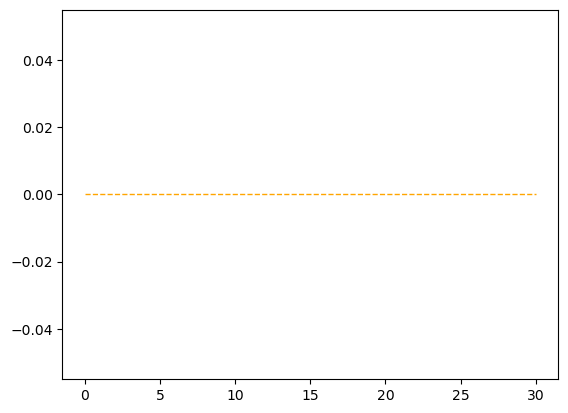

In [70]:
plt.plot(r, VVso, label='Spin-orbit Vso', color='orange', linewidth=1, linestyle='--')
plt.show()